In [1]:
from kubernetes import client, config
import pandas as pd
import matplotlib.pyplot as plt

from prometheus_api_client import PrometheusConnect

from datetime import datetime, timedelta
from difflib import diff_bytes
import matplotlib.pyplot as plt

In [2]:
# Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# Prometheus Config
#prom_url = "http://<PROMETHEUS_SERVER_IP>:<PORT>"
# prom_url = "http://10.110.188.57:9090"
prom_url = "http://10.105.116.175:9090"

prom = PrometheusConnect(url=prom_url, disable_ssl=True)
#test prom connection
prom_connect_response = prom.custom_query(query="up")
print(prom_connect_response)

[{'metric': {'__name__': 'up', 'app': 'compose-post-service', 'instance': '192.168.140.15:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network2', 'pod': 'compose-post-service-866f6d7b74-nsc75', 'pod_template_hash': '866f6d7b74', 'security_istio_io_tlsMode': 'istio', 'service': 'compose-post-service', 'service_istio_io_canonical_name': 'compose-post-service', 'service_istio_io_canonical_revision': 'latest'}, 'value': [1715831414.921, '1']}, {'metric': {'__name__': 'up', 'app': 'compose-post-service', 'instance': '192.168.18.199:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network', 'pod': 'compose-post-service-866f6d7b74-45swb', 'pod_template_hash': '866f6d7b74', 'security_istio_io_tlsMode': 'istio', 'service': 'compose-post-service', 'service_istio_io_canonical_name': 'compose-post-service', 'service_istio_io_canonical_revision': 'latest'}, 'value': [1715831414.921, '1']}, {'metric': {'__name__': 'up', 'app': 'details', 'instance': '192.168.231.244:15020', 'job': 'k

In [3]:
from datetime import datetime, timedelta

def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    # Define the end time as now
    end_time = datetime.now() - timedelta(minutes=60*2)
    # Define the start time as 'timerange' minutes before the end time
    start_time = end_time - timedelta(minutes=timerange)

    # Define the istio request query
    '''
    1) istio_tcp_sent_bytes_total{}: COUNTER which measures the size of total bytes sent during response in case of a TCP connection.
    2) istio_tcp_received_bytes_total{}: COUNTER which measures the size of total bytes received during request in case of a TCP connection
    '''
    istio_tcp_sent_query = f'istio_tcp_sent_bytes_total{{reporter="source",source_workload="{workload_src}",destination_workload="{workload_dst}"}}'
    istio_tcp_received_query = f'istio_tcp_received_bytes_total{{reporter="source",source_workload="{workload_src}",destination_workload="{workload_dst}"}}'

    # Fetch the data from Prometheus
    istio_tcp_sent_response = prom.custom_query_range(
        query=istio_tcp_sent_query,
        start_time=start_time,
        end_time=end_time,
        step=step_interval  # 300s = 5 minutes
    )
    istio_tcp_received_response = prom.custom_query_range(
        query=istio_tcp_received_query,
        start_time=start_time,
        end_time=end_time,
        step=step_interval  # 300s = 5 minutes
    )   
    
    # calculating the bi-directional traffic (in bytes) for source_workload and destination_workload
    
    # if both directions no traffic response:
    if (not istio_tcp_sent_response or not istio_tcp_sent_response[0]['values']) and (not istio_tcp_received_response or not istio_tcp_received_response[0]['values']): # the response is empty or the response values field is empty
        # print("No values found in the query")
        return 0  # In case no data is returned, means no transmitted requests, set to 0
    
    
    else:
        #if not istio_response is not empty, then continue the caculation
        values_sent = istio_tcp_sent_response[0]['values'] # values are value_pair, and value_pair is [timestamp, value]
        values_received = istio_tcp_received_response[0]['values']
                
        # Extract beginning and end value( sending traffic) pairs
        begin_timestamp, begin_traffic_sent_counter = values_sent[0] # return the first [timestamp, value] pair
        end_timestamp,end_traffic_sent_counter = values_sent[-1] # return the last [timestamp, value] pair
        # Extract beginning and end value( receiving traffic) pairs
        begin_timestamp, begin_traffic_received_counter = values_received[0]
        end_timestamp,end_traffic_received_counter = values_received[-1]        
        
        
        data_points_num_sent = len(values_sent) # equals the number of how many [timestamp, value] pair
        data_points_num_recevied = len(values_received) # equals the number of how many [timestamp, value] pair
        
        
        average_traffic_sent = (int(end_traffic_sent_counter)-int(begin_traffic_sent_counter))/data_points_num_sent
        average_traffic_received = (int(end_traffic_received_counter)-int(begin_traffic_received_counter))/data_points_num_recevied
        
        print(f"average_traffic_sent={average_traffic_sent}, average_traffic_received={average_traffic_received}")
        
        
        average_traffic_bytes = (average_traffic_sent+ average_traffic_received)/2
        return average_traffic_bytes

# Example usage, the average usage should be the (end_value_counter - begin_value_couter)/total_time_points
# different UM-DM pari, different bi-directional traffic
average_traffic = transmitted_req_calculator(workload_src="nginx-thrift", workload_dst="compose-post-service", timerange=120, step_interval='1m') # quering time length, timerange in Minutes
print(f"Average traffic (Byte) per 1 minutes: {average_traffic} (Byte)")

average_traffic = transmitted_req_calculator(workload_src="compose-post-service", workload_dst="text-service", timerange=120, step_interval='1m') # quering time length, timerange in Minutes
print(f"Average traffic (Byte) per 1 minutes: {average_traffic} (Byte)")

average_traffic = transmitted_req_calculator(workload_src="post-storage-service", workload_dst="post-storage-mongodb", timerange=120, step_interval='1m') # quering time length, timerange in Minutes
print(f"Average traffic (Byte) per 1 minutes: {average_traffic} (Byte)")

average_traffic = transmitted_req_calculator(workload_src="compose-post-service", workload_dst="post-storage-service", timerange=120, step_interval='1m') # quering time length, timerange in Minutes
print(f"Average traffic (Byte) per 1 minutes: {average_traffic} (Byte)")



average_traffic_sent=0.0, average_traffic_received=0.0
Average traffic (Byte) per 1 minutes: 0.0 (Byte)
average_traffic_sent=0.0, average_traffic_received=0.0
Average traffic (Byte) per 1 minutes: 0.0 (Byte)
average_traffic_sent=1898.1818181818182, average_traffic_received=345.12396694214874
Average traffic (Byte) per 1 minutes: 1121.6528925619834 (Byte)
average_traffic_sent=0.0, average_traffic_received=0.0
Average traffic (Byte) per 1 minutes: 0.0 (Byte)


In [4]:
# Configure API client
# config.load_kube_config()  # This loads your current kube config
# Initialize the Kubernetes client
# v1 = client.AppsV1Api()
namespace = 'social-network'  # Specify the namespace
def get_ready_deployments(namespace):
    ready_deployments = []
    # List deployments in the specified namespace
    deployments = client.AppsV1Api().list_namespaced_deployment(namespace)
    for deployment in deployments.items:
        # Check if the deployment is ready
        # "ready replicas" equals "replicas" indicates deployment is ready
        if deployment.status.ready_replicas == deployment.spec.replicas:
            ready_deployments.append(deployment.metadata.name)
    
    return ready_deployments

# Retrieve and print the list of ready deployments
ready_deployments = get_ready_deployments(namespace)
print("Ready Deployments:", ready_deployments)

Ready Deployments: ['compose-post-service', 'home-timeline-redis', 'home-timeline-service', 'jaeger', 'media-frontend', 'media-memcached', 'media-mongodb', 'media-service', 'nginx-thrift', 'post-storage-memcached', 'post-storage-mongodb', 'post-storage-service', 'social-graph-mongodb', 'social-graph-redis', 'social-graph-service', 'text-service', 'unique-id-service', 'url-shorten-memcached', 'url-shorten-mongodb', 'url-shorten-service', 'user-memcached', 'user-mention-service', 'user-mongodb', 'user-service', 'user-timeline-mongodb', 'user-timeline-redis', 'user-timeline-service']


average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=9187.2, average_traffic_received=1670.4
average_traffic_sent=9187.2, average_traffic_received=1670.4
average_traffic_sent=0.0, average_traffic_received=0.0
average_traffic_sent=0.0, average_traffic_received=0.

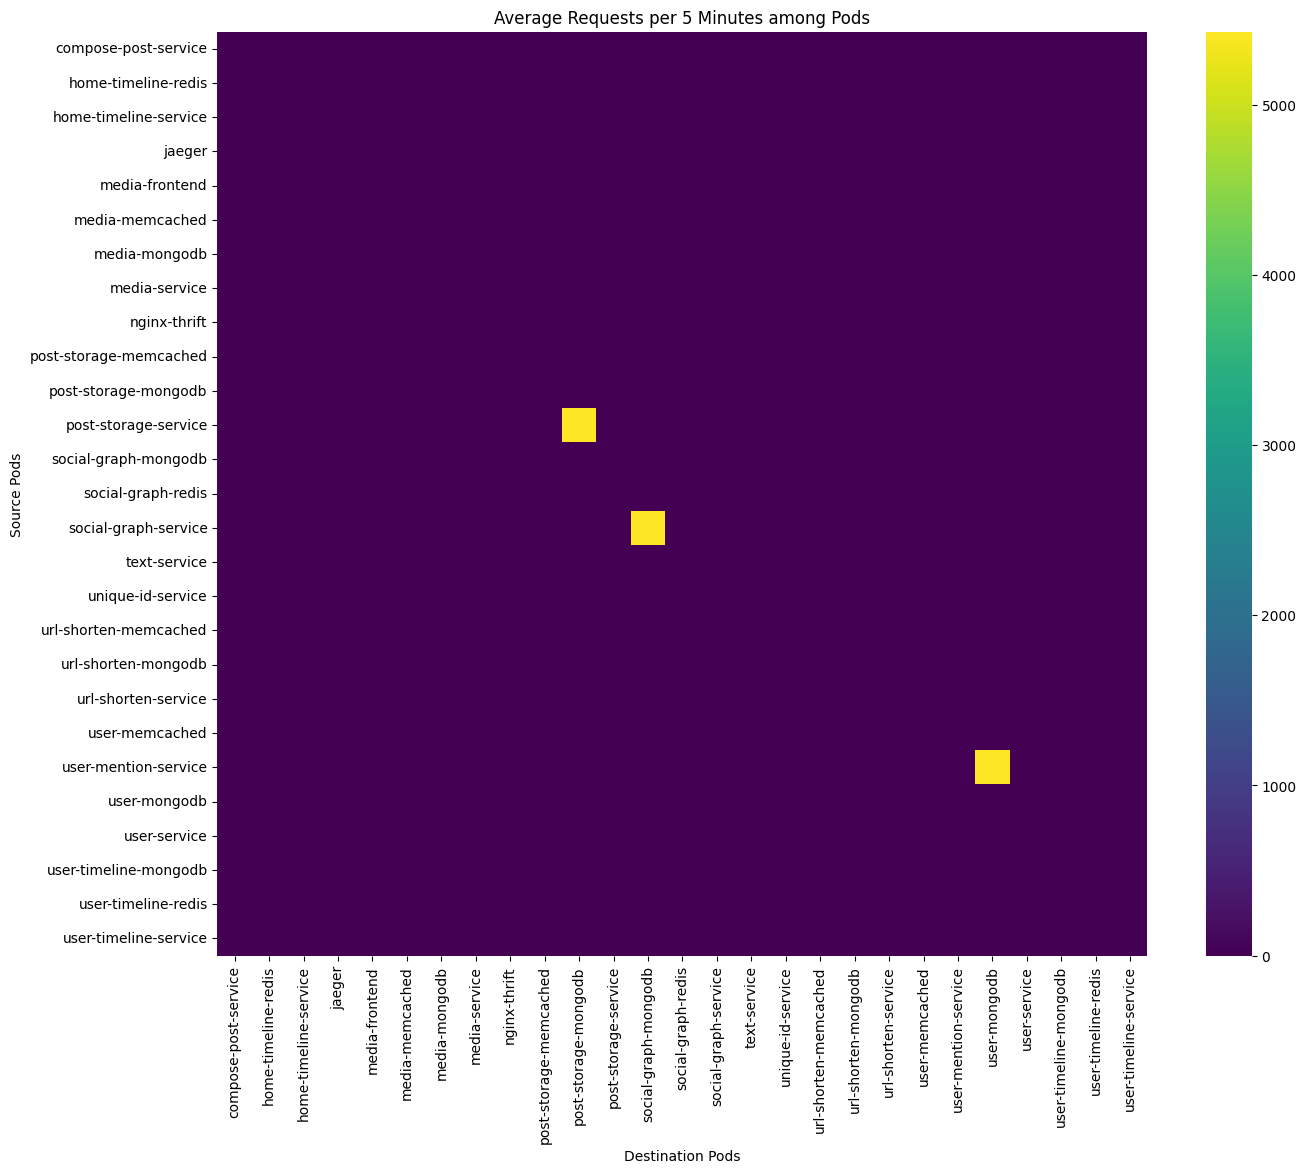

In [5]:
import seaborn as sns

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(workload_src=deployment_src, workload_dst=deployment_dst, timerange=120, step_interval='5m')
            df.at[deployment_src, deployment_dst] = average_requests

# Since the data might not represent a traditional correlation, directly plotting it
plt.figure(figsize=(15, 12))
sns.heatmap(df, cmap='viridis', fmt=".2f") #annot=True,  show values
# sns.heatmap(df, annot=False, cmap='viridis', fmt=".2f") # don't show the values

plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()
        

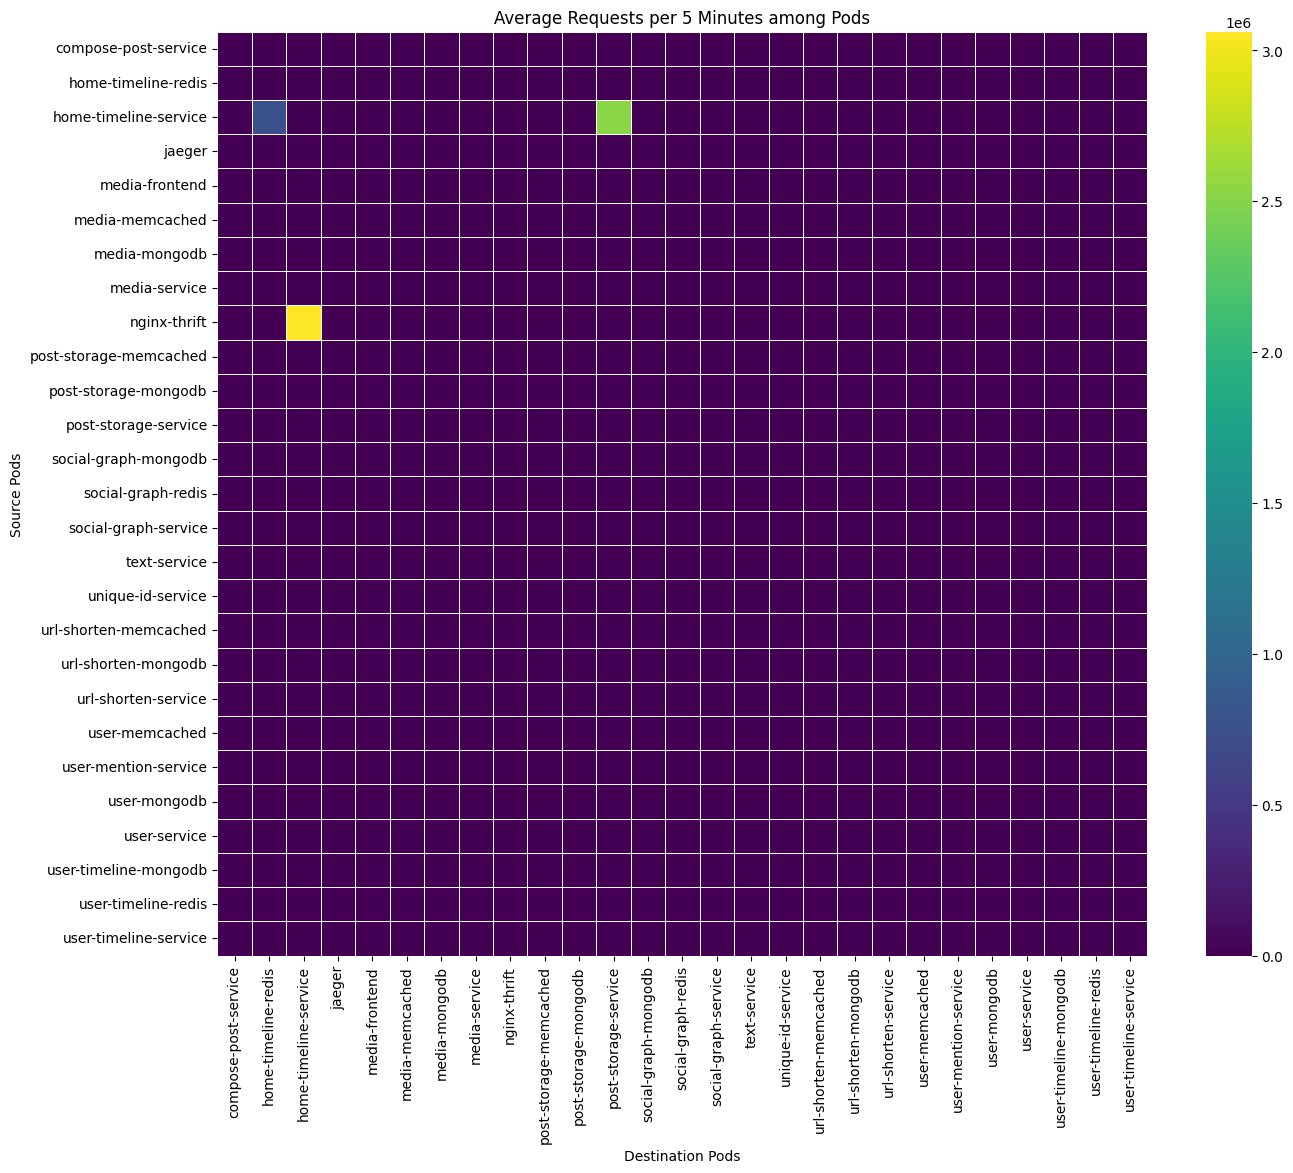

In [7]:
# Since the data might not represent a traditional correlation, directly plotting it
plt.figure(figsize=(15, 12))
sns.heatmap(df, cmap='viridis', fmt=".2f", linewidths=.5) #annot=True,  show values
# sns.heatmap(df, annot=False, cmap='viridis', fmt=".2f") # don't show the values

plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

In [21]:
#Updated: 11 April, 2024
#define Chain Element (upStream_Microservice, downStrem_Microservice, stress)
from collections import defaultdict

class ChainElement:  # CE <UM, DM Stress>
    def __init__(self, upStream_MS, downStream_MS, stress):
        # define three attributes of for each ChainElement
        self.upStream_MS = upStream_MS
        self.downStream_MS = downStream_MS
        self.stress = stress
    
    def __repr__(self):
        return f"<{self.upStream_MS}, {self.downStream_MS}, {self.stress}>"

# define the ChainPath
class ChainPathAnalysis:
    def __init__(self, chain_elements):
        self.chain_elements = chain_elements
        self.chain_graph = defaultdict(list)
        self._build_stress_graph()

    def _build_stress_graph(self):
        for chain in self.chain_elements:
            self.chain_graph[chain.upStream_MS].append((chain.downStream_MS, chain.stress)) # building the path by appending dependent microservices(UM->DM)
    '''
    build example:
    # Create some chain elements
            chain_elements = [
                ChainElement('MS1', 'MS2', 10),
                ChainElement('MS1', 'MS3', 20),
                ChainElement('MS2', 'MS4', 30),
            ]
            # Create a ChainPathAnalysis instance
            analysis = ChainPathAnalysis(chain_elements)
            # analysis.chain_graph is a defaultdict and it looks like this, which shows one UM could have mutiple DM:
            # MS1->MS2 (with stress 10), MS1->MS3 (with stress 20), MS2->MS4 (with stress 30)
            # {'MS1': [('MS2', 10), ('MS3', 20)], 'MS2': [('MS4', 30)]}
    '''

    def _find_all_ChainPaths(self, start_MS, end_MS, path=[], stress_sum=0, count=0): # 'ms' is abbration for microservice
        path = path + [start_MS] # a single path
        if start_MS == end_MS:
            # return [(path, stress_sum/count if count > 0 else 0)]
            if count > 0:
                average_stress = stress_sum / count
            else:
                average_stress = 0
            return [(path, average_stress)]
        
        if start_MS not in self.chain_graph:
            return []
        paths = [] # store all found paths
        for new_MS, stress in self.chain_graph[start_MS]: 
            if new_MS not in path: # new_MS is not included in the path
                newpaths = self._find_all_ChainPaths(new_MS, end_MS, path, stress_sum + stress, count + 1)
                for newpath in newpaths:
                    paths.append(newpath) # add the found new paths
        return paths

    # find the longest path in current networking environment
    # sort chain paths based on each path's stress
    def sort_chain_paths(self): 
        start_MSs = set(self.chain_graph.keys())
        end_MSs = set([chain.downStream_MS for chain in self.chain_elements]) - start_MSs

        all_paths = []
        for start_MS in start_MSs:
            for end_MS in end_MSs:
                all_paths.extend(self._find_all_ChainPaths(start_MS, end_MS))

        # Sort all chain paths by path's average stress
        sorted_chain_paths = sorted(all_paths, key=lambda x: x[1], reverse=True)
        return sorted_chain_paths

    def __repr__(self):
        return f"ChainPath Analysis with {len(self.chain_elements)} element chains"

In [22]:
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)
element_chains=[] # initail element_chains are empty, <upStream_pod, downStream_pod, transmit_frequency>
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(workload_src=deployment_src, workload_dst=deployment_dst, timerange=120, step_interval='5m')
            #find chain elements
            if 0<average_requests: # select the elementChain with real transmition
                element_chains.append(ChainElement(deployment_src, deployment_dst,average_requests))
            df.at[deployment_src, deployment_dst] = average_requests

element_chains

[<compose-post-service, home-timeline-service, 330.6>,
 <compose-post-service, media-service, 1298.96>,
 <compose-post-service, post-storage-service, 323.32>,
 <compose-post-service, text-service, 8681.68>,
 <compose-post-service, unique-id-service, 546.96>,
 <compose-post-service, user-service, 931.56>,
 <compose-post-service, user-timeline-service, 401.28>,
 <home-timeline-service, home-timeline-redis, 815.04>,
 <home-timeline-service, post-storage-service, 6862.56>,
 <home-timeline-service, social-graph-service, 233.96>,
 <nginx-thrift, compose-post-service, 899.44>,
 <nginx-thrift, home-timeline-service, 8587.44>,
 <nginx-thrift, user-timeline-service, 1531.76>,
 <post-storage-service, post-storage-mongodb, 9623.88>,
 <social-graph-service, social-graph-mongodb, 9941.4>,
 <social-graph-service, social-graph-redis, 24.0>,
 <text-service, url-shorten-service, 4641.92>,
 <text-service, user-mention-service, 509.48>,
 <user-mention-service, user-memcached, 514.56>,
 <user-mention-servi

In [23]:
# Analyze critical chains
analysis = ChainPathAnalysis(element_chains)
sorted_chain_paths = analysis.sort_chain_paths()

# Display the longest critical path(s) and their average frequency (with sorting)
print("Critical Path(s):")
for path, avg_stress in sorted_chain_paths:
    print(f"Path: {'->'.join(path)}, Average Stress (Reqs frequency): {avg_stress}")

Critical Path(s):
Path: user-mention-service->user-mongodb, Average Stress (Reqs frequency): 10273.8
Path: social-graph-service->social-graph-mongodb, Average Stress (Reqs frequency): 9941.4
Path: post-storage-service->post-storage-mongodb, Average Stress (Reqs frequency): 9623.88
Path: nginx-thrift->home-timeline-service->post-storage-service->post-storage-mongodb, Average Stress (Reqs frequency): 8357.96
Path: home-timeline-service->post-storage-service->post-storage-mongodb, Average Stress (Reqs frequency): 8243.22
Path: compose-post-service->text-service->url-shorten-service, Average Stress (Reqs frequency): 6661.8
Path: compose-post-service->text-service->user-mention-service->user-mongodb, Average Stress (Reqs frequency): 6488.32
Path: nginx-thrift->home-timeline-service->social-graph-service->social-graph-mongodb, Average Stress (Reqs frequency): 6254.266666666666
Path: compose-post-service->home-timeline-service->post-storage-service->post-storage-mongodb, Average Stress (Reqs 